# Characterising the impact of tropical cyclones on mangroves

**Background** This notebook forms one step in a workflow used to produce local wind fields for selected severe tropical cyclones to hit the Australian mainland. Cyclones were first modelled using Geoscience Australia's [Tropical Cyclone Risk Model](https://github.com/GeoscienceAustralia/tcrm). Note that cyclones prior to ~2005 do not have the required observational input data for this model, and so only cyclones post 2005 were included. The cyclones included in this study are:
* Ingrid (2005)
* Larry (2006)
* Monica (2006)
* George (2007)
* Laurence (2010)
* Yasi (2011)
* Lam (2015)
* Marcia (2015)

The workflow after the regional wind fields were modelled has been included in this notebook, as well as the intermediate and final output locations.

**What this notebook does**
This notebook opens a regional wind field, and allows the user to select a region within this extent. The selected extent is used to carry out a DEA extraction that collects the `pq_mask` data for a random time slice. The `landsea` pq flag (Boolean) is selected, and the maximum for value over the time slice is selected to combine the available passes and maximise the extent of the available mask. This mask is used to produce a highly simplified 'land cover' dataset, that only differentiates between medium roughness vegetation and water. This land cover dataset is then exported to Geotiff.

**Author** Claire Krause

**Date** 29/3/2018

In [1]:
% pylab notebook
from datacube.storage import masking
import datacube 
from datetime import datetime
from skimage import exposure
import xarray as xr
import cartopy.crs as ccrs
from datacube.helpers import ga_pq_fuser
import os

import sys
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEAPlotting
import DEADataHandling

#dcman = datacube.Datacube(config='/home/156/cek156/mangroves.conf')
dc = datacube.Datacube(app='mangrove')

Populating the interactive namespace from numpy and matplotlib


In [2]:
storm = 'LAURENCE'

# Load in the windfield dataset

In [3]:
wind = xr.open_dataset('/g/data/r78/mangroves/{0}/windfield/gust.001-00001.nc'.format(storm))

## Use the map widgets to zoom the map into the required extent

**Note: Try to limit the extent as much as possible to avoid memory errors!**

<IPython.core.display.Javascript object>


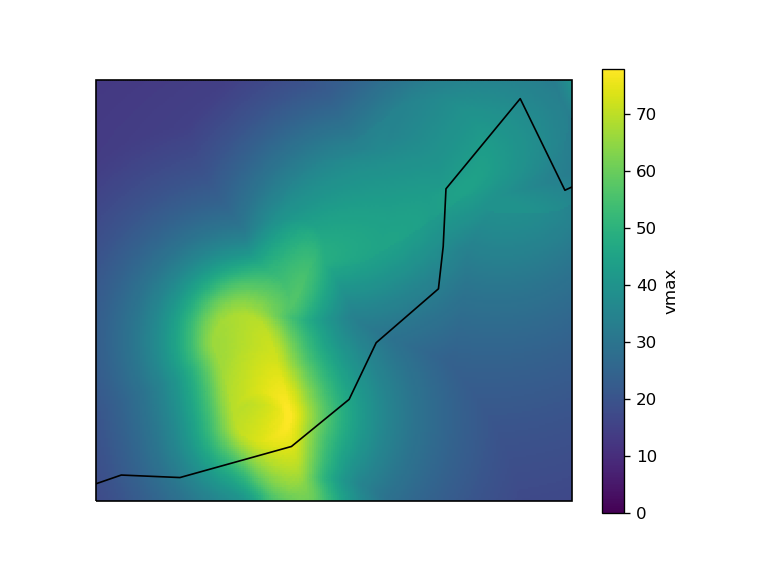

In [4]:
fig, axes = plt.subplots()
ax = plt.subplot(projection=ccrs.PlateCarree())
wind.vmax.plot.pcolormesh(ax=ax, infer_intervals=True)
ax.coastlines()

# Grab land sea mask for the area of interest

For the purposes of this study, we can just grab the land/sea mask that is provided with the Landsat data. Note that this may not be 100% correct, however given that we are simply using it to develop a generic land surface roughness dataset, this should have minimal effect on the final result.

In [5]:
lon1, lon2, lat1, lat2 = ax.get_extent()

query = {
        'lat': (lat1, lat2),
        'lon': (lon1, lon2),
        'time':('2015-06-01', '2015-06-30')
        }

data = dc.load(product='ls8_pq_albers', group_by='solar_day', **query)

In [6]:
mask_components = {'land_sea' : 'land'}
landsea_mask = masking.make_mask(data, **mask_components)

In [7]:
landmerge = landsea_mask.pixelquality.max(dim = 'time')

## Check the mask looks ok

<IPython.core.display.Javascript object>


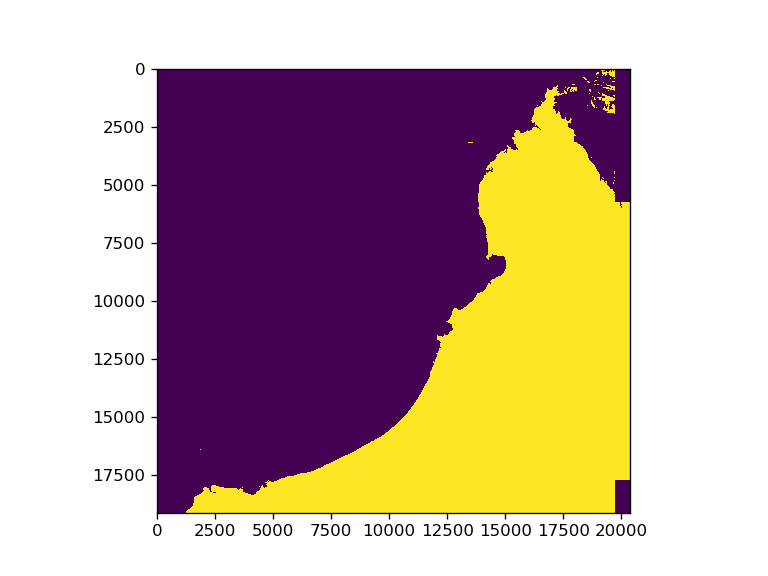

In [8]:
fig, axes = plt.subplots()
plt.imshow(landmerge)

# Now we need to create our land cover mask

We will be using a very rough estimate on landcover, focussing on vegetation that exists along the coastline, within the mangrove extent.

Surface roughness estimates can be found in the Australian/New Zealand building Standard AS/NZS 1170.2 Supp 1, 2002. Structural design actions-Wind actions-Commentary. Values relevant from this standard were extracted for inclusion in the GA Publication [Local Wind Assessment in Australia, Computation Methodology for Wind Multipliers](http://pid.geoscience.gov.au/dataset/75299
), produced in 2014. This publication outlines the processes for calculating wind multipliers (which is ultimately what this landcover product is feeding in to). 

This publication highlights the following landcover types, and their associated surface roughness values:

|Terrain classes |Terrain roughness length (m) |Terrain category|
|----------------|-----------------------------|----------------|
|City buildings| 2 |4.00|
|Forest |1 |3.70|
|High density (industrial) buildings |0.8 |3.60|
|Small town centres |0.4 |3.30|
|Suburban/wooded country |0.2 |3.00|
|Orchard, open forest| 0.08 |2.60|
|Long grass with few trees |0.06 |2.48|
|Crops |0.04 |2.30|
|Open rough water, airfields, uncut grass etc. |0.02 |2.00|
|Cut grass |0.008| 1.60|
|Desert (stones), roads |0.006 |1.48|
|Mudflats/salt evaporators/sandy beaches |0.004 |1.30|
|Snow surface |0.002 |1.00|

We will pick a mid-range surface roughness value of **0.2** to assign to all land values

In [9]:
landcover = landmerge.to_dataset(name = 'surfaceRoughness') * 0.2 # sneaky trick to convert boolean to 0 /1 
landcover.attrs['crs'] = data.crs
landcover.attrs['affine'] = data.affine

In [10]:
DEADataHandling.dataset_to_geotiff('/g/data/r78/mangroves/WindMultiplierInputs/{0}_LandCover_region2.tif'
                                   .format(storm), landcover)

## Landcover datasets produced by this code
* GEORGE_LandCover_region1.tif
* INGRID_LandCover_region1.tif
* INGRID_LandCover_region2.tif
* INGRID_LandCover_region3.tif
* LAM_LandCover_region1.tif
* LARRY_LandCover_region1.tif
* LAURENCE_LandCover_region1.tif
* LAURENCE_LandCover_region2.tif
* MARCIA_LandCover_region1.tif
* MONICA_LandCover_region1.tif
* MONICA_LandCover_region2.tif
* YASI_LandCover_region1.tif

# Preparing the other datasets for the wind multipliers code

The wind multipliers code requires two dynamic inputs: land cover and topography.

The code above produces the landcover input, which is a highly simplified classification based on land/ocean.

The topography data comes from the [SRTM-derived 1 Second Digital Elevation Models Version 1.0](http://pid.geoscience.gov.au/dataset/72759). A polygon was drawn for the region required for each cyclone, converted to a feature layer, and then used to clip the DEM dataset. Each subset DEM was then exported as a geotiff file and moved onto the NCI, to `/g/data/r78/mangroves/WindMultiplierInputs`.

The Australia-wide dataset was opened in ArcGIS, and cropped to capture just the landfall region for each TC. Some regions overlapped between cyclones, and so the same extent was used for multiple simulations.

| Cyclone name | Landfall DEM 1 | Landfall DEM 2 | Landfall DEM 3 |
|--------------|------------|------------|------------|
| George | GEOR | - | - |
| Ingrid | ING1 | ING2 | ING3 |
| Lam | ING2 | - | - |
| Larry | LARR | - | - |
| Laurence | LAUR | - | - |
| Marcia | MARC | - | - |
| Monica | ING1 | ING2 | - |
| Yasi | LARR | - | - |

# Calculating the wind multipliers

The wind multipliers are calculated using the [Wind_multipliers](https://github.com/GeoscienceAustralia/Wind_multipliers) model. This code requires the land cover and topography datasets as input. 

| Cyclone | DEM | Landcover | Output |
|---------|-----|-----------|--------|
| George | dem1sv1_0GEOR.tif | GEORGE_LandCover_region1.tif | WM1 |
| Ingrid (1) | dem1sv1_0ING1.tif | INGRID_LandCover_region1.tif | WM1 |
| Ingrid (2) | dem1sv1_0ING2.tif | INGRID_LandCover_region2.tif | WM2 |
| Ingrid (3) | dem1sv1_0ING3.tif | INGRID_LandCover_region3.tif | WM3 | 
| Lam | dem1sv1_0ING2.tif | LAM_LandCover_region1.tif | WM1 |
| Larry | dem1sv1_0LARR.tif | LARRY_LandCover_region1.tif | WM1 | 
| Laurence (1) | dem1sv1_0LAUR.tif | LAURENCE_LandCover_region1.tif | WM1 | 
| Laurence (2) | dem1sv1_0LAUR.tif | LAURENCE_LandCover_region2.tif | WM2 | 
| Marcia | dem1sv1_0MARC.tif | MARCIA_LandCover_region1.tif | WM1 |
| Monica (1) | dem1sv1_0ING1.tif | MONICA_LandCover_region1.tif | WM1 |
| Monica (2) | dem1sv1_0ING2.tif | MONICA_LandCover_region2.tif | WM2 | 
| Yasi | dem1sv1_0LARR.tif | YASI_LandCover_region1.tif | WM1 |

# Process multipliers

The final step in producing the local wind field involves correcting the regional wind field using the newly calculated wind multipliers. This is done using the `ProcessMultipliers` code available in the `develop` branch of the [TCRM github repo](https://github.com/GeoscienceAustralia/tcrm/tree/develop).

An example of the configuration file used to run this code is provided below:

The list of tile names for each run was compiled from the list of files produced by the wind multipliers model. 

| Cyclone | Tiles |
|---------|-------|
| George |e114.9729s19.5320_,e114.9729s20.5320_,e114.9729s21.5320_,e114.9729s22.5320_,e115.9729s19.5320_,e115.9729s20.5320_,<br> e115.9729s21.5320_,e115.9729s22.5320_,e116.9729s19.5320_,e116.9729s20.5320_,e116.9729s21.5320_,e116.9729s22.5320_,<br> e117.9729s19.5320_,e117.9729s20.5320_,e117.9729s21.5320_,e117.9729s22.5320_,e118.9729s19.5320_,e118.9729s20.5320_,<br> e118.9729s21.5320_,e118.9729s22.5320_,e119.9729s19.5320_,e119.9729s20.5320_,e119.9729s21.5320_,e119.9729s22.5320_,<br> e120.9729s19.5320_,e120.9729s20.5320_,e120.9729s21.5320_,e120.9729s22.5320_| 
| Ingrid (1) |e142.7651s12.5006_,e142.7651s13.5006_,e142.7651s14.5006_,e142.7651s15.5006_,e142.7651s16.5006_,e143.7651s12.5006_,<br>e143.7651s13.5006_,e143.7651s14.5006_,e143.7651s15.5006_,e143.7651s16.5006_,e144.7651s13.5006_,e144.7651s14.5006_,<br>e144.7651s15.5006_,e144.7651s16.5006_,e145.7651s16.5006_ |
| Ingrid (2) |e130.0301s11.1493_,e130.0301s12.1493_,e130.0301s13.1493_,e131.0301s11.1493_,e131.0301s12.1493_,e131.0301s13.1493_,<br>e132.0301s11.1493_,e132.0301s12.1493_,e132.0301s13.1493_,e133.0301s11.1493_,e133.0301s12.1493_,e133.0301s13.1493_,<br>e134.0301s11.1493_,e134.0301s12.1493_,e134.0301s13.1493_,e135.0301s11.1493_,e135.0301s12.1493_,e135.0301s13.1493_,<br>e136.0301s11.1493_,e136.0301s12.1493_,e136.0301s13.1493_|
| Ingrid (3) |e125.5034s13.5768_,e125.5034s14.5768_,e126.5034s13.5768_,e126.5034s14.5768_,e127.5034s13.5768_,e127.5034s14.5768_|
| Lam |e130.0301s11.1493_,e130.0301s12.1493_,e130.0301s13.1493_,e131.0301s11.1493_,e131.0301s12.1493_,e131.0301s13.1493_,<br>e132.0301s11.1493_,e132.0301s12.1493_,e132.0301s13.1493_,e133.0301s11.1493_,e133.0301s12.1493_,e133.0301s13.1493_,<br>e134.0301s11.1493_,e134.0301s12.1493_,e134.0301s13.1493_,e135.0301s11.1493_,e135.0301s12.1493_,e135.0301s13.1493_,<br>e136.0301s11.1493_,e136.0301s12.1493_,e136.0301s13.1493_|
| Larry |e145.2968s17.0693_,e145.2968s18.0693_,e145.2968s19.0693_,e146.2968s17.0693_,e146.2968s18.0693_,e146.2968s19.0693_|
| Laurence (1) |e120.6920s17.8965_,e120.6920s18.8965_,e121.6920s15.8965_,e121.6920s16.8965_,e121.6920s17.8965_,e121.6920s18.8965_,<br>e122.6920s15.8965_,e122.6920s16.8965_,e122.6920s17.8965_,e122.6920s18.8965_,e123.6920s14.8965_|
| Laurence (2) |e120.6920s17.8965_,e120.6920s18.8965_,e121.6920s15.8965_,e121.6920s16.8965_,e121.6920s17.8965_,e121.6920s18.8965_,<br>e122.6920s15.8965_,e122.6920s16.8965_,e122.6920s17.8965_|
| Marcia |e149.1229s21.5618_,e149.1229s22.5618_,e149.1229s23.5618_,e149.1229s24.5618_,e150.1229s21.5618_,e150.1229s22.5618_,<br>e150.1229s23.5618_,e150.1229s24.5618_,e151.1229s22.5618_,e151.1229s23.5618_,e151.1229s24.5618_,e152.1229s24.5618_,|
| Monica (1) |e142.7651s12.5006_,e142.7651s13.5006_,e142.7651s14.5006_,e142.7651s15.5006_,e142.7651s16.5006_,e143.7651s12.5006_,<br>e143.7651s13.5006_,e143.7651s14.5006_,e143.7651s15.5006_,e143.7651s16.5006_,e144.7651s13.5006_,e144.7651s14.5006_,<br>e144.7651s15.5006_,e144.7651s16.5006_,e145.7651s16.5006_|
| Monica (2) |e130.0301s11.1493_,e130.0301s12.1493_,e130.0301s13.1493_,e131.0301s11.1493_,e131.0301s12.1493_,e131.0301s13.1493_,<br>e132.0301s11.1493_,e132.0301s12.1493_,e132.0301s13.1493_,e133.0301s11.1493_,e133.0301s12.1493_,e133.0301s13.1493_,<br>e134.0301s11.1493_,e134.0301s12.1493_,e134.0301s13.1493_,e135.0301s11.1493_,e135.0301s12.1493_,e135.0301s13.1493_,<br>e136.0301s11.1493_,e136.0301s12.1493_,e136.0301s13.1493_|
| Yasi |e145.2968s17.0693_,e145.2968s18.0693_,e145.2968s19.0693_,e146.2968s17.0693_,e146.2968s18.0693_,e146.2968s19.0693_|

## Running Process Multipliers

Due to the large number of tiles that need to be processed for each TC, the jobs were submitted to raijin, instead of being run from an interactive node.

# Final outputs

* George : `/g/data/r78/mangroves/GEORGE/windfield/local_wind.tif` *checked*
* Ingrid (1) : `/g/data/r78/mangroves/INGRID/windfield1/local_wind.tif` *checked*
* Ingrid (2) : `/g/data/r78/mangroves/INGRID/windfield2/local_wind.tif` *checked*
* Ingrid (3) : `/g/data/r78/mangroves/INGRID/windfield3/local_wind.tif` *checked*
* Lam : `/g/data/r78/mangroves/LAM/windfield/local_wind.tif` *checked*
* Larry : `/g/data/r78/mangroves/LARRY/windfield/local_wind.tif` *checked*
* Laurence (1) : still running...
* Laurence (2) : still running...
* Marcia : `/g/data/r78/mangroves/MARCIA/windfield/local_wind.tif` *checked*
* Monica (1) : `/g/data/r78/mangroves/MONICA/windfield1/local_wind.tif` *checked*
* Monica (2) : `/g/data/r78/mangroves/MONICA/windfield2/local_wind.tif` *checked - is extent ok?*
* Yasi : `/g/data/r78/mangroves/YASI/windfield/local_wind.tif` *checked*

**A symbolic link for each of these datasets was created in the folder `/g/data/r78/mangroves/FINALlocalWind`, so they are all available in one place.**